# Introduction

This notebook demonstrates some basic data handling using the Pandas package and the application of linear methods to identify relationships in materials data. We will be creating a rudimentary prediction model for the bulk modulus of an element from various basic elemental properties. For the purposes of this exercise, we will assume that a linear relationship does indeed exist.

In [ ]:
from __future__ import annotations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

params = {
    "legend.fontsize": 20,
    "figure.figsize": (12, 8),
    "axes.labelsize": 20,
    "axes.titlesize": 24,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
mpl.rcParams.update(params)

Load in the elemental dataset using pandas' read_csv method. This data was obtained from the Materials Project for the ground state structure of each element only. The columns are:
- K: Bulk modulus in GPa
- MP: Melting point in K
- BP: Boiling point in K
- Z: Atomic number
- X: Pauling electronegativity
- r: Atomic radius in angstroms

In [ ]:
data_url = "https://raw.githubusercontent.com/materialsvirtuallab/nano281/master/lectures/notebooks/element_data.csv"
data = pd.read_csv(data_url, index_col=0)
print(data)

             K       MP      BP   Z     X     r
Element                                        
Ac        29.0  1323.00  3573.0  89  1.10  1.95
Ag        88.0  1234.93  2435.0  47  1.93  1.60
Al        83.0   933.47  2792.0  13  1.61  1.25
As        40.0  1090.00   887.0  33  2.18  1.15
Au       137.0  1337.33  3129.0  79  2.54  1.35
...        ...      ...     ...  ..   ...   ...
W        304.0  3695.00  5828.0  74  2.36  1.35
Y         41.0  1799.00  3609.0  39  1.22  1.80
Yb        15.0  1097.00  1469.0  70  1.10  1.75
Zn        67.0   692.68  1180.0  30  1.65  1.35
Zr        94.0  2128.00  4682.0  40  1.33  1.55

[83 rows x 6 columns]


Since a strict linear relationship may not exist between K and the other variables, we will create a few additional features based on simple transformations of some of the inputs, namely the electronegativity and the atomic radius.

In [ ]:
data["X^2"] = data["X"] ** 2
data["sqrt(X)"] = data["X"] ** 0.5
data["r^2"] = data["r"] ** 2
data["sqrt(r)"] = data["r"] ** 0.5
print(data)

             K       MP      BP   Z     X     r     X^2   sqrt(X)     r^2  \
Element                                                                     
Ac        29.0  1323.00  3573.0  89  1.10  1.95  1.2100  1.048809  3.8025   
Ag        88.0  1234.93  2435.0  47  1.93  1.60  3.7249  1.389244  2.5600   
Al        83.0   933.47  2792.0  13  1.61  1.25  2.5921  1.268858  1.5625   
As        40.0  1090.00   887.0  33  2.18  1.15  4.7524  1.476482  1.3225   
Au       137.0  1337.33  3129.0  79  2.54  1.35  6.4516  1.593738  1.8225   
...        ...      ...     ...  ..   ...   ...     ...       ...     ...   
W        304.0  3695.00  5828.0  74  2.36  1.35  5.5696  1.536229  1.8225   
Y         41.0  1799.00  3609.0  39  1.22  1.80  1.4884  1.104536  3.2400   
Yb        15.0  1097.00  1469.0  70  1.10  1.75  1.2100  1.048809  3.0625   
Zn        67.0   692.68  1180.0  30  1.65  1.35  2.7225  1.284523  1.8225   
Zr        94.0  2128.00  4682.0  40  1.33  1.55  1.7689  1.153256  2.4025   

For ease of interpretation, let's define our X and y.

In [ ]:
features = [c for c in data.columns if c != "K"]
x = data[features]
y = data["K"]

We will now perform a standard multiple linear regression using scikit-learn.

K = -243.8 + 4.25e-02 MP + 2.76e-02 BP + -2.48e-01 Z + 3.92e+02 X + -3.55e+02 r + -4.96e+01 X^2 + -3.85e+02 sqrt(X) + 5.40e+01 r^2 + 5.00e+02 sqrt(r)


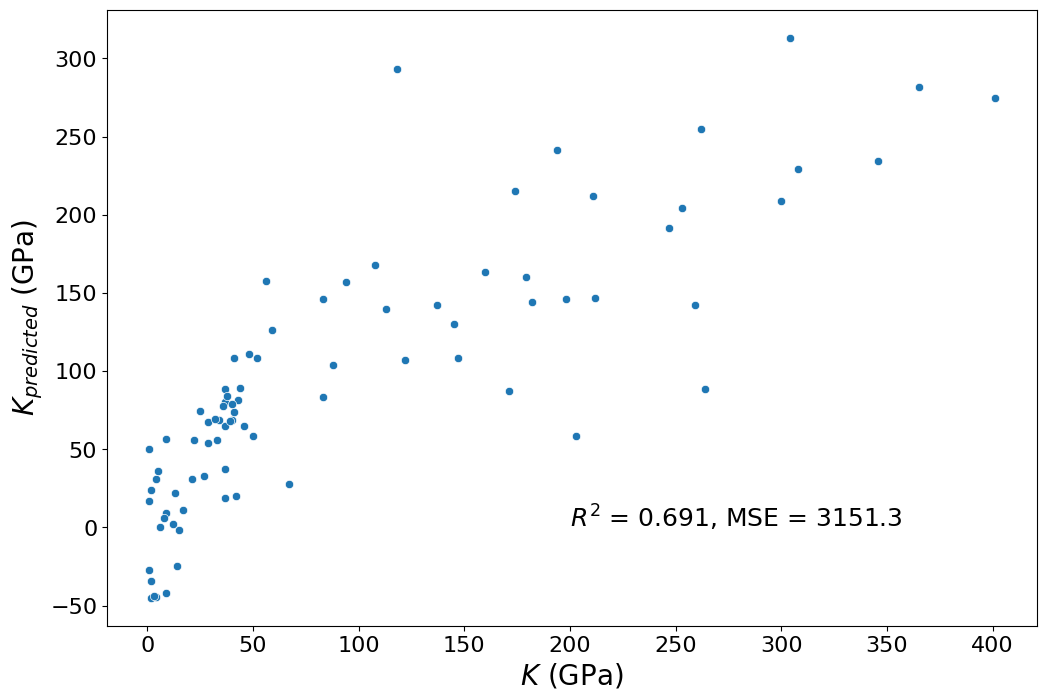

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

reg = linear_model.LinearRegression()
reg.fit(x, y)
r2 = reg.score(x, y)
equation = [f"{v:.2e} {f}" for v, f in zip(reg.coef_, features, strict=False)]
print("K = {:.1f} + {}".format(reg.intercept_, " + ".join(equation)))
f, ax = plt.subplots(figsize=(12, 8))
yhat = reg.predict(data[features])
sns.scatterplot(x=y, y=yhat)
plt.ylabel(r"$K_{predicted}$ (GPa)")
plt.xlabel(r"$K$ (GPa)")
plt.annotate(
    rf"$R^2$ = {r2:.3f}, MSE = {mean_squared_error(y, yhat):.1f}",
    (200, 0),
    fontsize=18,
);

Now, it may seem that this model performs very well. But in actuality, we have used the entire dataset to perform the regression. A proper fit should be conducted using cross-validation. Here, we will use a five-fold cross-validation to assess the performance of this highly overspecified model.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
display(X_train)
display(X_test)
display(y_train)
display(y_test)

,MP,BP,Z,X,r,X^2,sqrt(X),r^2,sqrt(r)
Element,,,,,,,,,
Cd,594.22,1040.00,48,1.69,1.55,2.8561,1.300000,2.4025,1.244990
P,317.30,550.00,15,2.19,1.00,4.7961,1.479865,1.0000,1.000000
Ir,2739.00,4701.00,77,2.20,1.35,4.8400,1.483240,1.8225,1.161895
Tb,1629.00,3503.00,65,1.10,1.75,1.2100,1.048809,3.0625,1.322876
La,1193.00,3743.00,57,1.10,1.95,1.2100,1.048809,3.8025,1.396424
...,...,...,...,...,...,...,...,...,...
Er,1802.00,3141.00,68,1.24,1.75,1.5376,1.113553,3.0625,1.322876
S,388.36,717.87,16,2.58,1.00,6.6564,1.606238,1.0000,1.000000
Te,722.66,1261.00,52,2.10,1.40,4.4100,1.449138,1.9600,1.183216


,MP,BP,Z,X,r,X^2,sqrt(X),r^2,sqrt(r)
Element,,,,,,,,,
Ho,1734.00,2993.00,67,1.23,1.75,1.5129,1.109054,3.0625,1.322876
Ac,1323.00,3573.00,89,1.10,1.95,1.2100,1.048809,3.8025,1.396424
F,53.53,85.03,9,3.98,0.50,15.8404,1.994994,0.2500,0.707107
I,386.85,457.40,53,2.66,1.40,7.0756,1.630951,1.9600,1.183216
Cu,1357.77,3200.00,29,1.90,1.35,3.6100,1.378405,1.8225,1.161895
Hf,2506.00,4876.00,72,1.30,1.55,1.6900,1.140175,2.4025,1.244990
C,3800.00,4300.00,6,2.55,0.70,6.5025,1.596872,0.4900,0.836660
Pr,1208.00,3563.00,59,1.13,1.85,1.2769,1.063015,3.4225,1.360147
Au,1337.33,3129.00,79,2.54,1.35,6.4516,1.593738,1.8225,1.161895


Element
Cd     42.0
P      21.0
Ir    346.0
Tb     40.0
La     25.0
      ...  
Er     44.0
S       1.0
Te     22.0
Cl      2.0
Pd    160.0
Name: K, Length: 74, dtype: float64

Element
Ho     43.0
Ac     29.0
F       2.0
I       5.0
Cu    145.0
Hf    108.0
C     118.0
Pr     32.0
Au    137.0
Name: K, dtype: float64

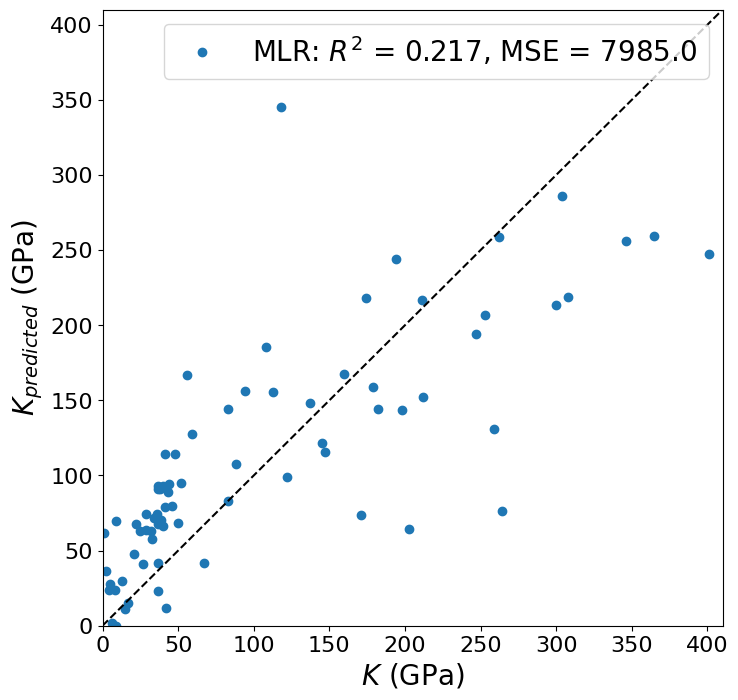

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_predict

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mlr = linear_model.LinearRegression()
yhat_mlr = cross_val_predict(mlr, x, y, cv=kfold)
r2_mlr = r2_score(y, yhat_mlr)
mse_mlr = mean_squared_error(y, yhat_mlr)
label_mlr = f"MLR: $R^2$ = {r2_mlr:.3f}, MSE = {mse_mlr:.1f}"

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, "o", label=label_mlr)
plt.ylabel(r"$K_{predicted}$ (GPa)")
plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], "k--");

# Correlations between features

Here, we will look at correlations between features. First, we do a pair plot between features.

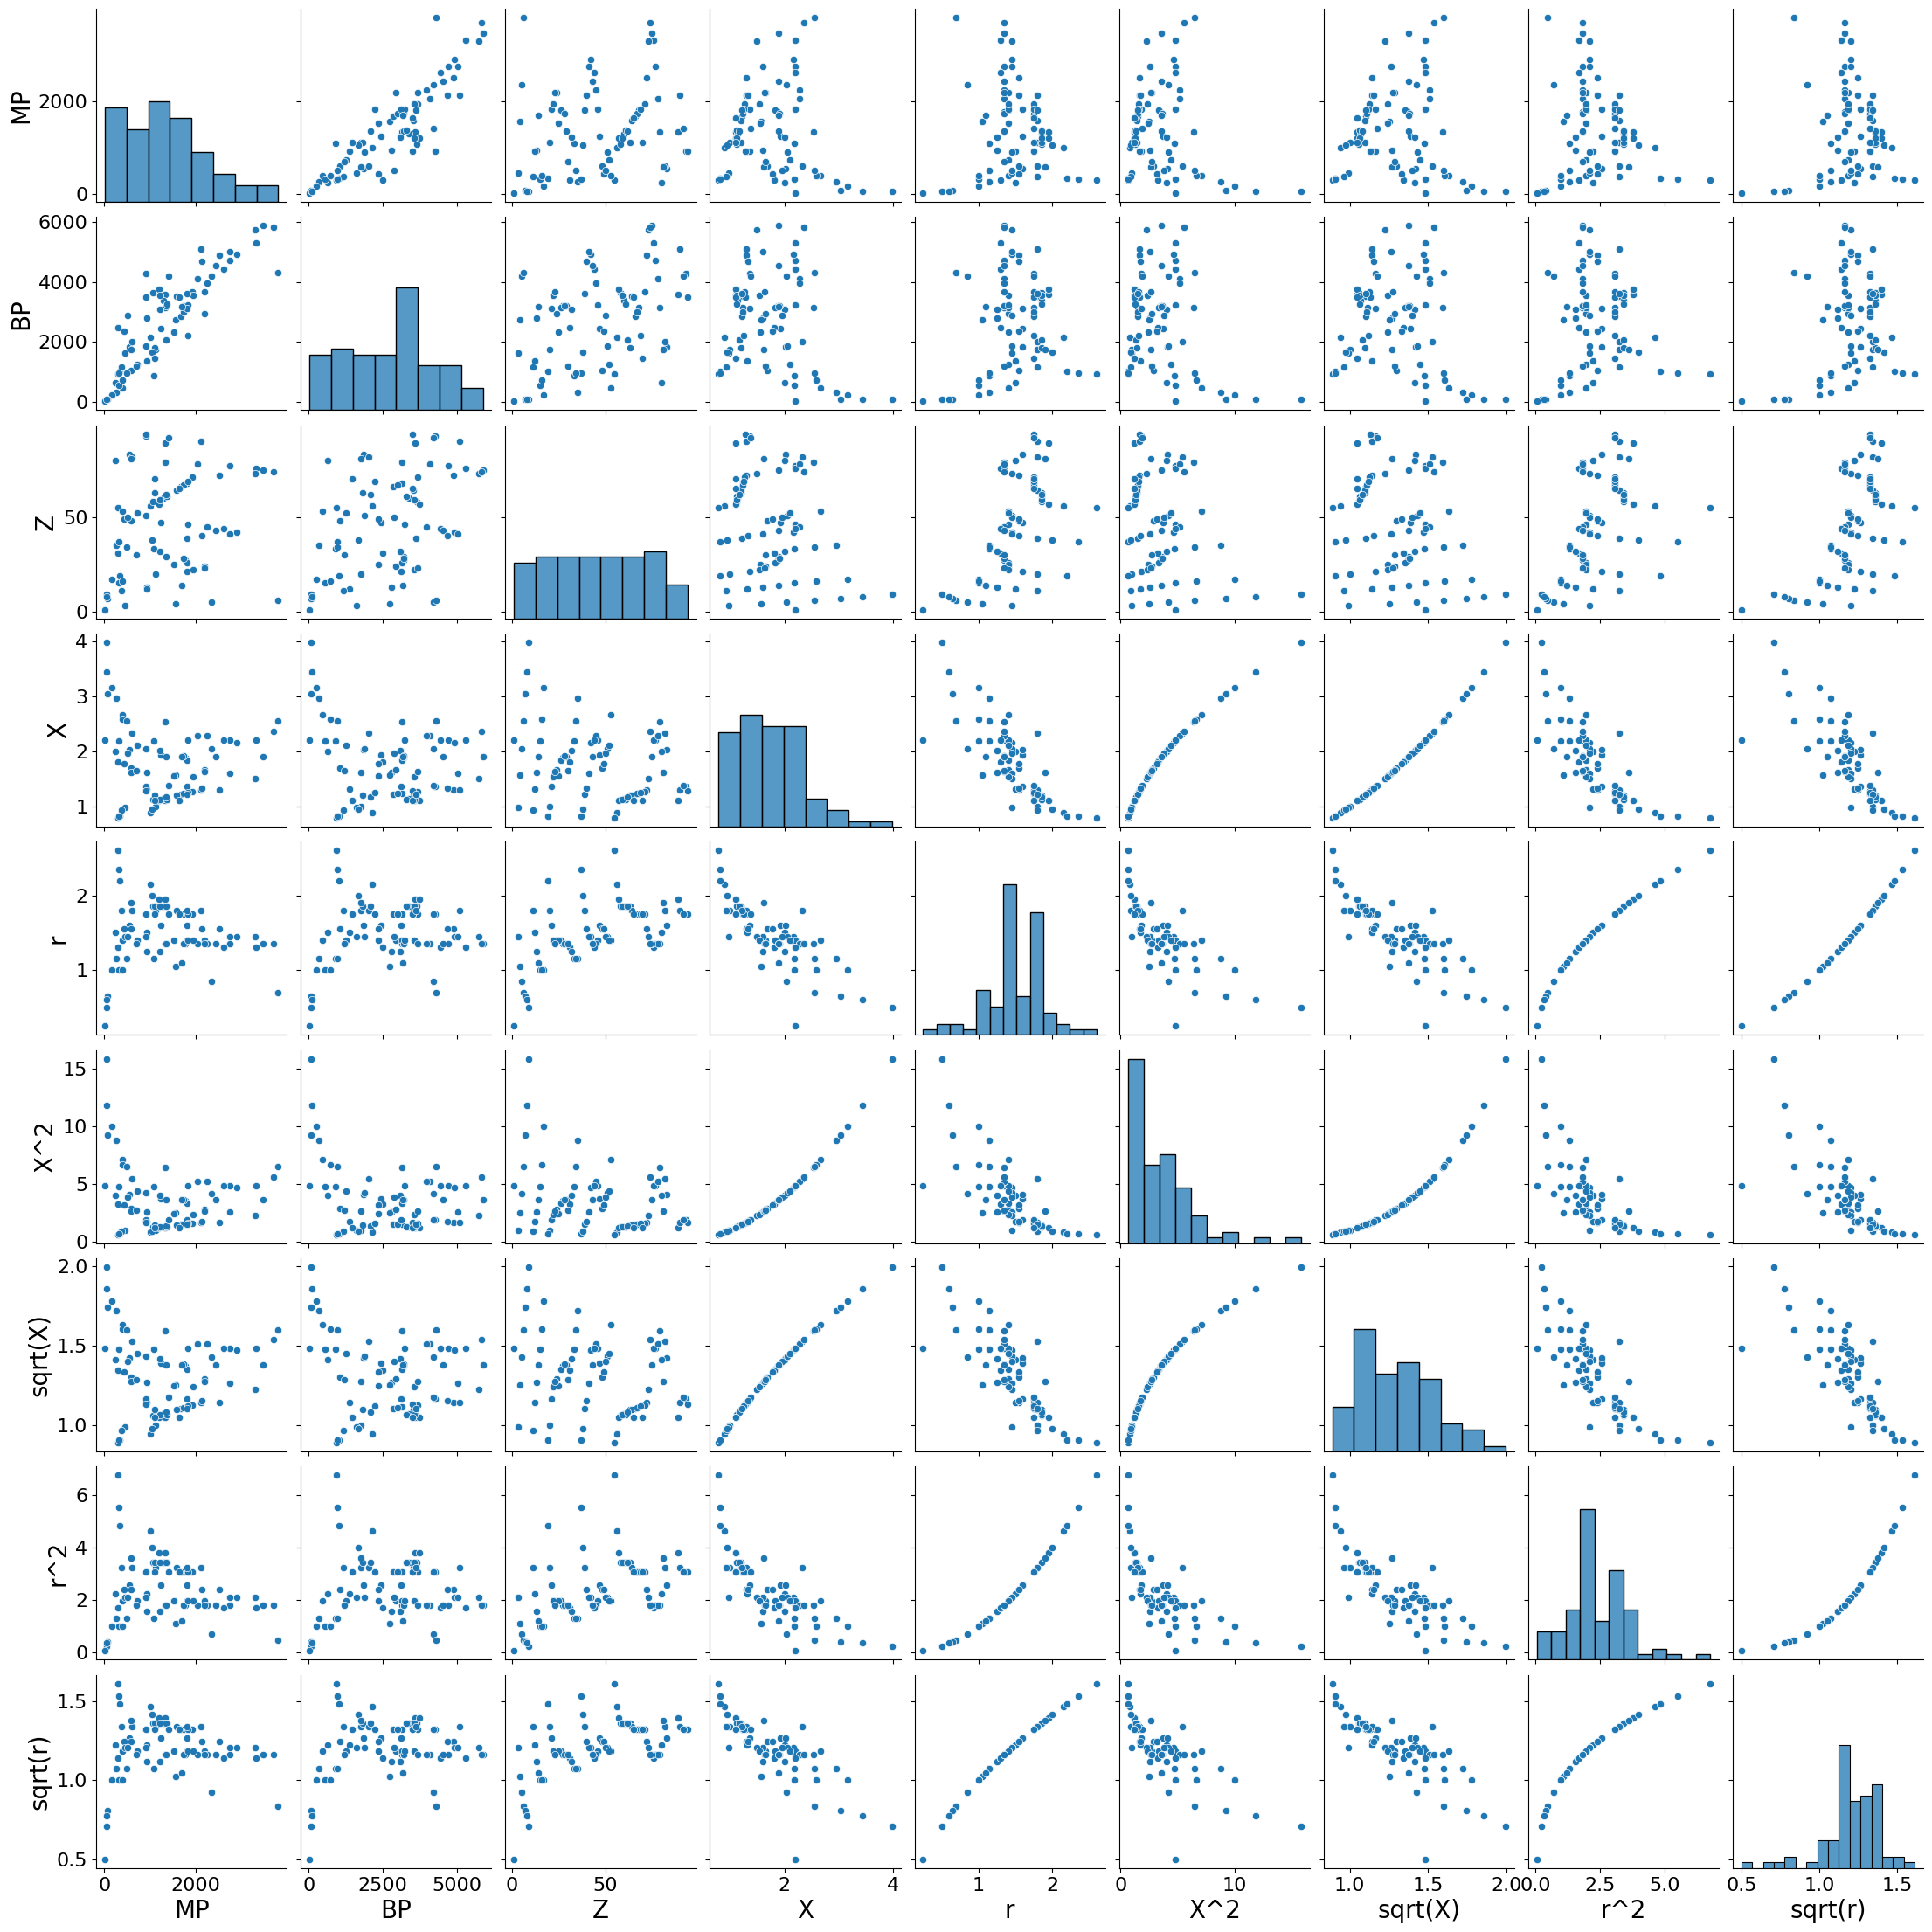

In [ ]:
grid = sns.pairplot(data[features])

From the plot, it is clear that MP and BP are correlated with each other. And X is inversely related to r in some way. Obviously, X and $X^2$ are correlated. Another way to plot this is using a correlation plot.

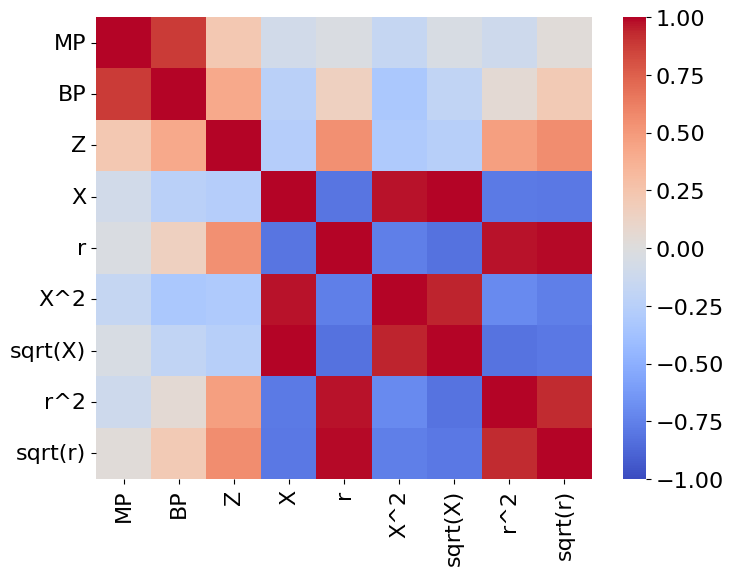

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(x.corr(), cmap="coolwarm", vmin=-1, vmax=1, ax=ax);

# Subset selection

Sometimes, the input variables may not be directly related to the interested target. Hence, a feature selection step is necessary. There are many different methods for selecting features. Here we will go over a simple implementation in scikit-learn,

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression


def identify_columns(x_new, nrows=10):
    columns = x.columns
    xvalues = x.values
    dist = np.linalg.norm(xvalues[:nrows, :, None] - x_new[:nrows, None, :], axis=0)
    return columns[np.argmin(dist, axis=0)].values


sel = SelectKBest(f_regression, k=3)
x_new = sel.fit_transform(x, y)
print(f"Selected features {identify_columns(x_new)}")

Selected features ['MP' 'BP' 'r^2']


In [ ]:
s = ", ".join([f"{i}: {j:.3e}" for i, j in zip(x.columns, sel.pvalues_, strict=False)])
print("The p values for the variables are " + s)

The p values for the variables are MP: 5.017e-17, BP: 3.285e-14, Z: 1.382e-01, X: 1.760e-01, r: 9.118e-02, X^2: 6.985e-01, sqrt(X): 6.706e-02, r^2: 1.346e-02, sqrt(r): 2.524e-01


Apparently, the most significant variables are MP and BP, followed by r^2 (p values < 0.05). Let's redo the regression using only these variables.

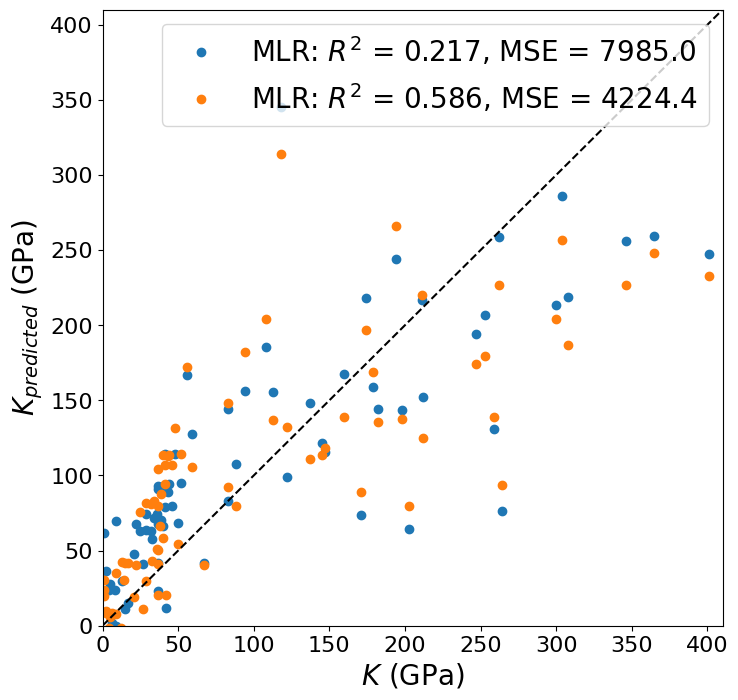

In [ ]:
mlr_best = linear_model.LinearRegression()
yhat_mlr_best = cross_val_predict(mlr_best, x_new, y, cv=kfold)
r2_mlr_best = r2_score(y, yhat_mlr_best)
mse_mlr_best = mean_squared_error(y, yhat_mlr_best)
label_mlr_best = f"MLR: $R^2$ = {r2_mlr_best:.3f}, MSE = {mse_mlr_best:.1f}"

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, "o", label=label_mlr)
plt.plot(y, yhat_mlr_best, "o", label=label_mlr_best)
l = plt.ylabel(r"$K_{predicted}$ (GPa)")
l = plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], "k--");

We can see that the best subset model has substantially reduced MSE and improved R2. 

# Shrinkage

Here, we will use shrinkage methods to shrink the feature coefficients. It is a best practice to first center the inputs and scale to unit variance prior to performing shrinkage. We will use scikit-learn's StandardScaler which performs this scaling.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)
means_ = scaler.mean_
stds_ = scaler.scale_
z = scaler.transform(x)
print(x)
print(z)

              MP      BP   Z     X     r     X^2   sqrt(X)     r^2   sqrt(r)
Element                                                                     
Ac       1323.00  3573.0  89  1.10  1.95  1.2100  1.048809  3.8025  1.396424
Ag       1234.93  2435.0  47  1.93  1.60  3.7249  1.389244  2.5600  1.264911
Al        933.47  2792.0  13  1.61  1.25  2.5921  1.268858  1.5625  1.118034
As       1090.00   887.0  33  2.18  1.15  4.7524  1.476482  1.3225  1.072381
Au       1337.33  3129.0  79  2.54  1.35  6.4516  1.593738  1.8225  1.161895
...          ...     ...  ..   ...   ...     ...       ...     ...       ...
W        3695.00  5828.0  74  2.36  1.35  5.5696  1.536229  1.8225  1.161895
Y        1799.00  3609.0  39  1.22  1.80  1.4884  1.104536  3.2400  1.341641
Yb       1097.00  1469.0  70  1.10  1.75  1.2100  1.048809  3.0625  1.322876
Zn        692.68  1180.0  30  1.65  1.35  2.7225  1.284523  1.8225  1.161895
Zr       2128.00  4682.0  40  1.33  1.55  1.7689  1.153256  2.4025  1.244990

## Ridge regression

Unlike the simple MLR example, we will do our ridge regression properly using k-fold cross-validation to identify the best shrinkage factor (denoted as the argument alpha in scikit-learn's implementation). We will use the MSE as the criterion in which to determine the best alpha.

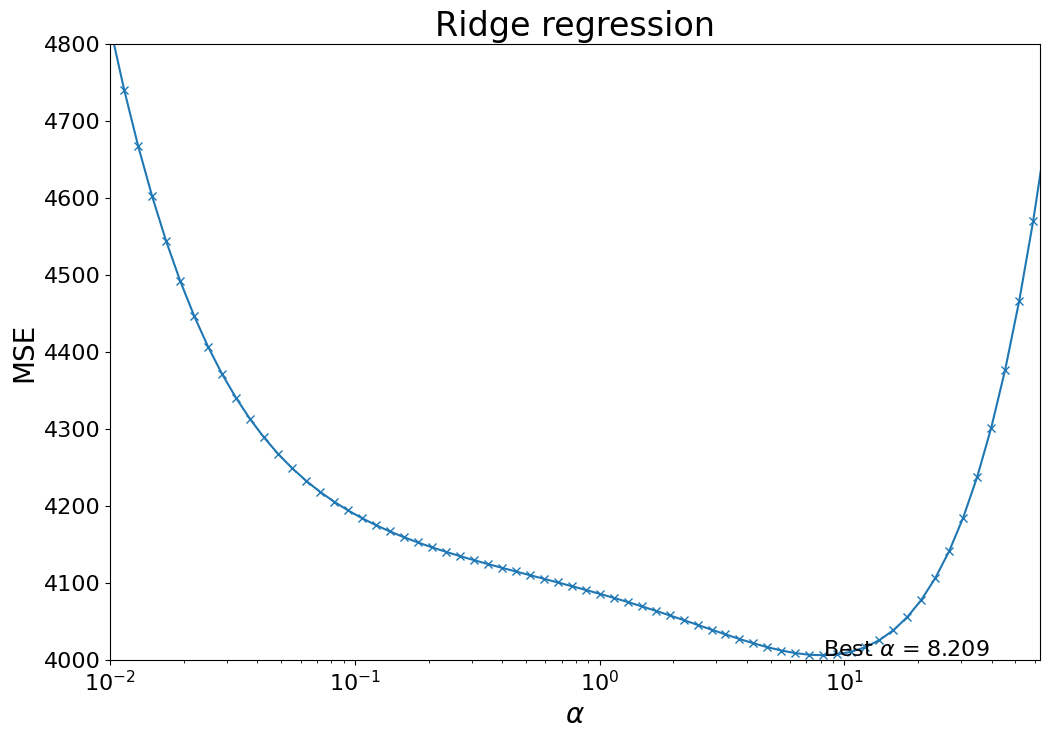

In [ ]:
from sklearn.model_selection import KFold, cross_validate

cv_results = []
coeffs = []
alphas = np.logspace(-2, 2, 71)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(z, y)
    scores = cross_validate(ridge, z, y, cv=kfold, scoring="neg_mean_squared_error")
    cv_results.append([alpha, -np.mean(scores["test_score"]), *list(ridge.coef_)])

cv_results = pd.DataFrame(cv_results, columns=["alpha", "score", *features])
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(cv_results["alpha"], cv_results["score"], "-x")
plt.xlim([1e-2, 10**1.8])
plt.ylim((4000, 4800))
plt.xscale(r"log")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"MSE")
plt.title(r"Ridge regression")
best_alpha = cv_results["alpha"][cv_results["score"].idxmin()]
plt.annotate(
    rf"Best $\alpha$ = {best_alpha:.3f}",
    (best_alpha, cv_results["score"].min()),
    fontsize=16,
);

Here, we will take a look at the effect of alpha on the coefficients. Note that these are for the scaled coefficients, i.e., the coefficients that map the scaled inputs to the output, and not the unscaled inputs.

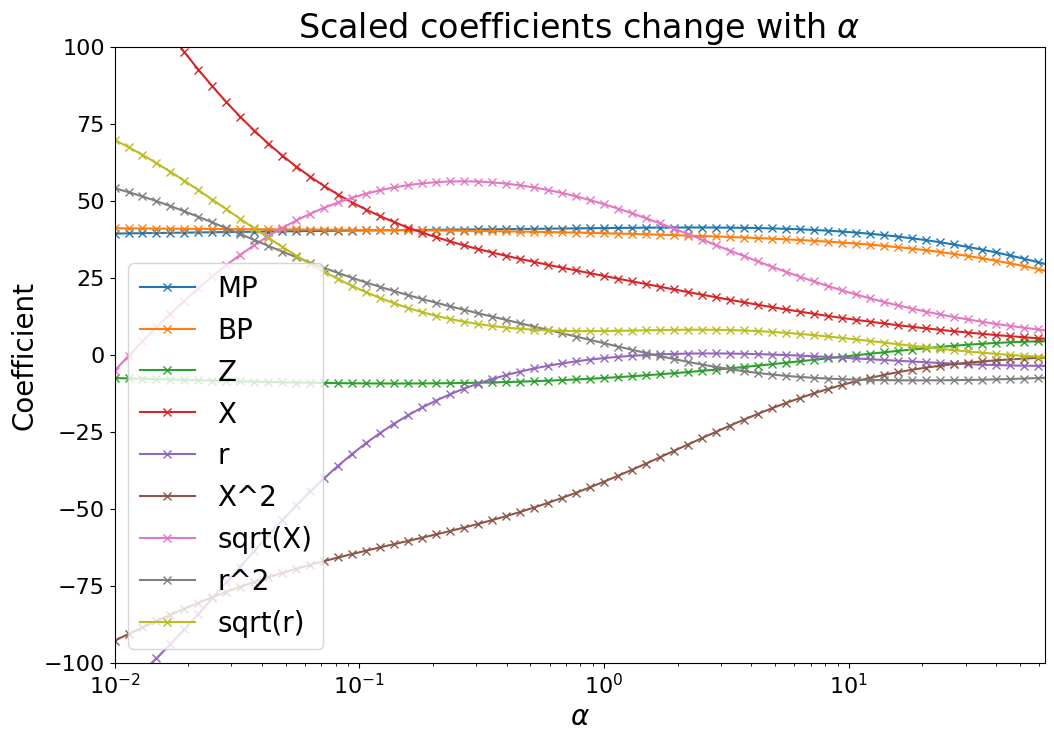

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], "-x", label=f)
    plt.xscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Coefficient")
    plt.title(r"Scaled coefficients change with $\alpha$")
plt.legend()
plt.xlim([1e-2, 10**1.8])
plt.ylim([-100, 100]);

Using the best alpha, we will now regenerate the final relationship. Note that we have to rescale the intercepts and coefficients back to the unnormalized inputs (multiply all coefficients by the respective standard deviations of the inputs, and shift all means).

In [ ]:
reg = linear_model.Ridge(alpha=best_alpha, max_iter=10000)
reg.fit(z, y)

real_coef = reg.coef_ / stds_  # convert back to unnormalized inputs
real_interp = reg.intercept_ - means_.dot(real_coef)  # convert back to unnormalized inputs

equation = [f"{v:.2e} {f}" for v, f in zip(real_coef, features, strict=False)]
print("K = {:.1f} + {}".format(real_interp, " + ".join(equation)))

K = -196.3 + 4.44e-02 MP + 2.43e-02 BP + -4.78e-02 Z + 1.98e+01 X + -2.00e+00 r + -4.27e+00 X^2 + 9.56e+01 sqrt(X) + -6.84e+00 r^2 + 3.33e+01 sqrt(r)


Here, we will redo our MLR with cross validation and compare with the ridge regression.

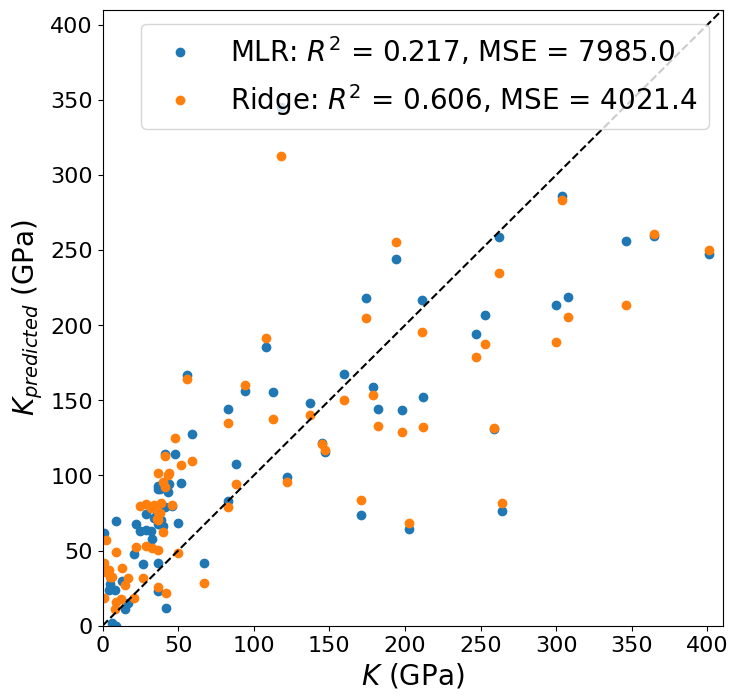

In [ ]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict

ridge = linear_model.Ridge(alpha=best_alpha, max_iter=10000)
yhat_ridge = cross_val_predict(ridge, z, y, cv=kfold)
r2_ridge = r2_score(y, yhat_ridge)
mse_ridge = mean_squared_error(y, yhat_ridge)
label_ridge = f"Ridge: $R^2$ = {r2_ridge:.3f}, MSE = {mse_ridge:.1f}"

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, "o", label=label_mlr)
plt.plot(y, yhat_ridge, "o", label=label_ridge)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], "k--");

## LASSO

Here, we will perform a LASSO regression using the same process as the ridge regression.

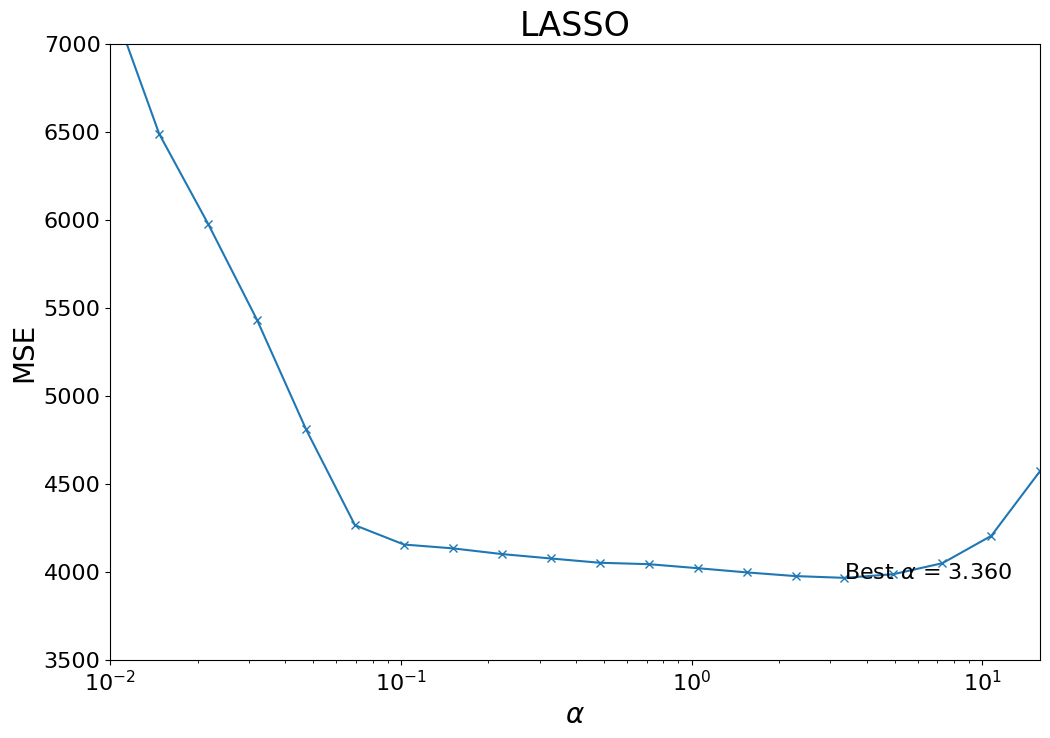

In [ ]:
alphas = np.logspace(-2, 1.2, 20)
cv_results = []
coeffs = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=100000)
    lasso.fit(z, y)
    scores = cross_validate(lasso, z, y, cv=kfold, scoring="neg_mean_squared_error")
    cv_results.append([alpha, -np.mean(scores["test_score"]), *list(lasso.coef_)])

cv_results = pd.DataFrame(cv_results, columns=["alpha", "score", *features])
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(cv_results["alpha"], cv_results["score"], "-x")
plt.xlim([1e-2, 10**1.2])
plt.ylim((3500, 7000))
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("MSE")
plt.title("LASSO")
best_alpha = cv_results["alpha"][cv_results["score"].idxmin()]
plt.annotate(
    rf"Best $\alpha$ = {best_alpha:.3f}",
    (best_alpha, cv_results["score"].min()),
    fontsize=16,
);

At a certain shrinkage factor, several of the coefficients have been shrunk to zero.

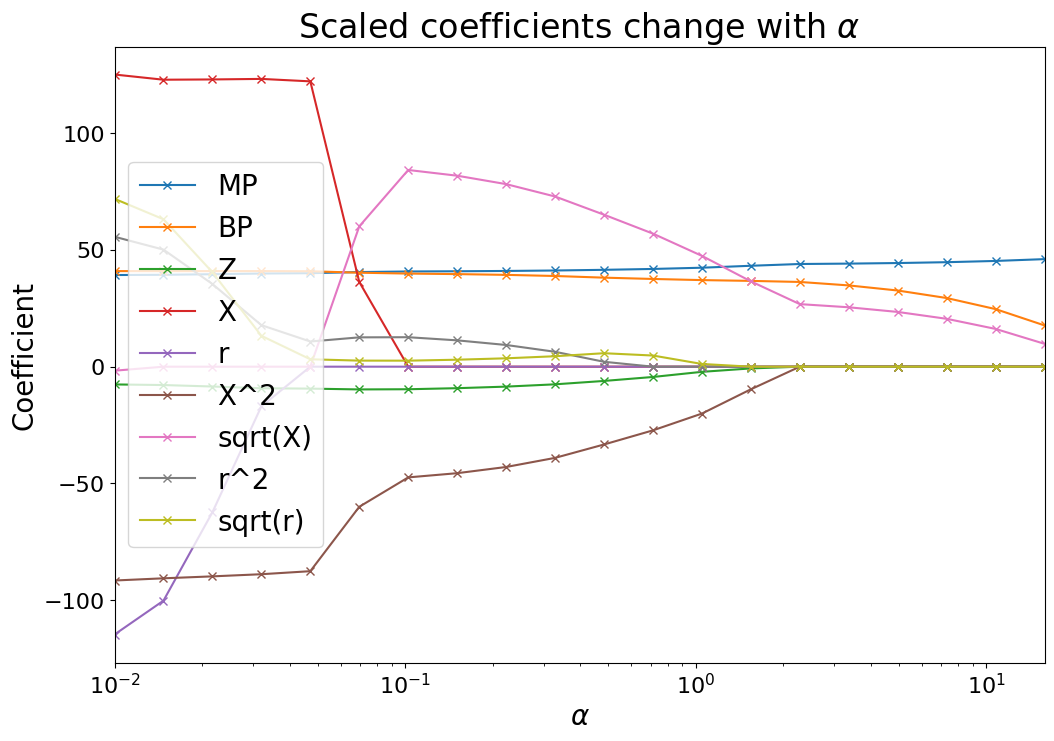

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], "-x", label=f)
    plt.xscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("Coefficient")
    plt.title(r"Scaled coefficients change with $\alpha$")
plt.legend()
plt.xlim([1e-2, 10**1.2]);

We will now retrieve the final equation, ignoring the coefficients that are zero. We note that the atomic number Z no longer appears in the equation. This is somewhat in line with intuition since we do not expect atomic number to have a significant relationship with the bulk modulus. As you may recall, the electronegativity and atomic radius are inversely correlated with each other. So we would expect only one of these parameters to be needed to describe the bulk modulus. Furthermore, it seems that the bulk modulus should be related to sqrt(X) and not X.

In [ ]:
reg = linear_model.Lasso(alpha=best_alpha, max_iter=10000)
reg.fit(z, y)

real_coef = reg.coef_ / stds_  # convert back to unnormalized inputs
real_interp = reg.intercept_ - means_.dot(real_coef)  # convert back to unnormalized inputs

equation = [f"{v:.2e} {f}" for v, f in zip(real_coef, features, strict=False) if abs(v) > 1e-4]
print("K = {:.1f} + {}".format(real_interp, " + ".join(equation)))

K = -178.1 + 4.87e-02 MP + 2.31e-02 BP + 1.09e+02 sqrt(X)


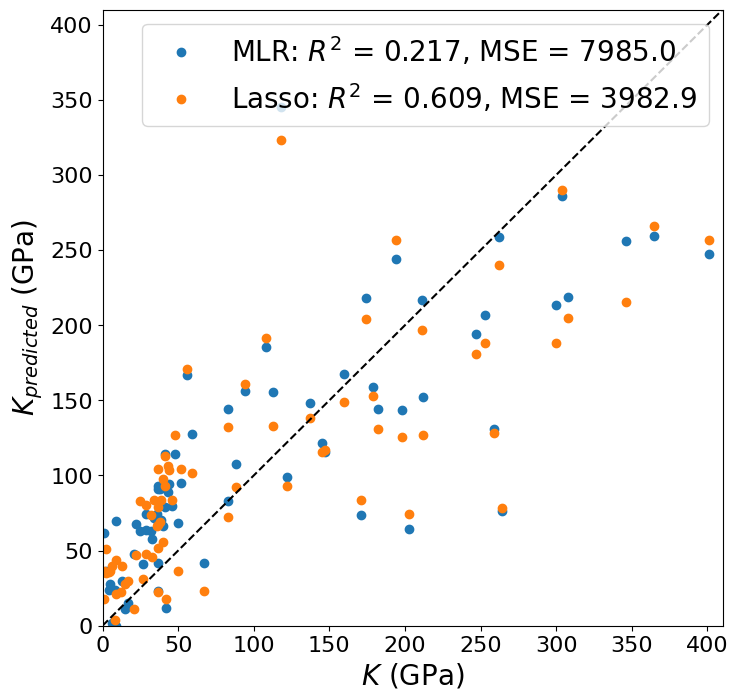

In [ ]:
lasso = linear_model.Lasso(alpha=best_alpha, max_iter=10000)
yhat_lasso = cross_val_predict(lasso, z, y, cv=kfold)
r2_lasso = r2_score(y, yhat_lasso)
mse_lasso = mean_squared_error(y, yhat_lasso)
label_lasso = f"Lasso: $R^2$ = {r2_lasso:.3f}, MSE = {mse_lasso:.1f}"

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, "o", label=label_mlr)
plt.plot(y, yhat_lasso, "o", label=label_lasso)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], "k--");

# Partial Least Squares

Here, we will do a 2-component PLS regression.

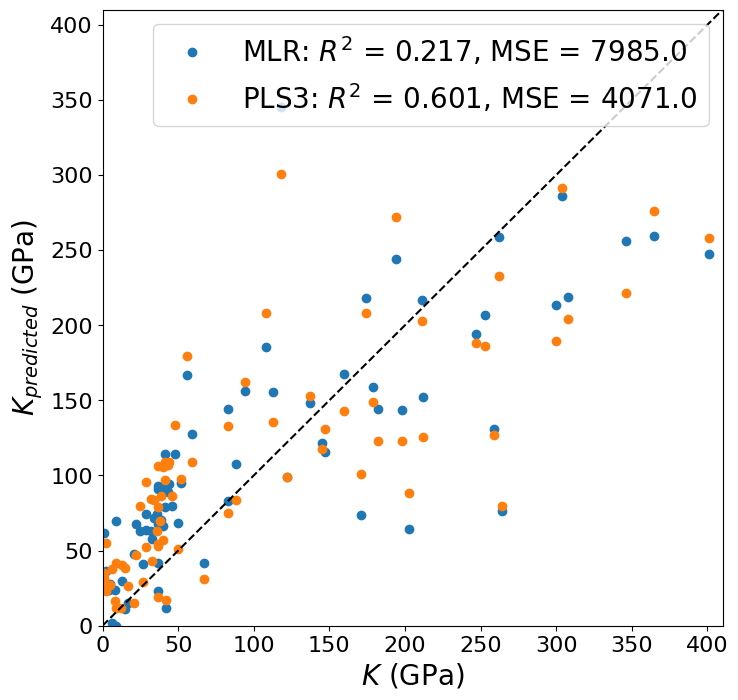

In [ ]:
from sklearn.cross_decomposition import PLSRegression

cv_results = []
coeffs = []
pls = PLSRegression(n_components=2)
pls.fit(x, y)
yhat_pls = cross_val_predict(pls, x, y, cv=kfold)
r2_pls = r2_score(y, yhat_pls)
mse_pls = mean_squared_error(y, yhat_pls)
label_pls = f"PLS3: $R^2$ = {r2_pls:.3f}, MSE = {mse_pls:.1f}"

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, "o", label=label_mlr)
plt.plot(y, yhat_pls, "o", label=label_pls)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], "k--");